### Introduction
“Face mask identification” typically refers to the process of detecting whether a person is wearing a face mask and, if so, how it is being worn (properly or incorrectly). This technology is part of the broader category of object detection in computer vision, where the object of interest is a face with or without a mask. This project utilizes YOLOv8, a state-of-the-art object detection model, known for its speed and accuracy. With its advanced capabilities, YOLOv8 enables efficient face-mask detection by training on annotated datasets and deploying for real-world applications.
- The field of facial recognition has seen rapid advances with the development of deep learning models, especially with the YOLO (You Only Look Once) family of algorithms. Recent versions of YOLO, such as YOLOv8, continue to build on the foundations of previous versions by incorporating more complex neural network architecture and optimization techniques. These advances have further improved YOLO’s ability to detect smaller objects, improving accuracy while maintaining the speed needed for real-time applications. These advances have further improved YOLO’s ability to detect smaller objects, improving accuracy while maintaining the speed needed for real-time applications
- These studies provide a solid foundation for the present work, which focuses on the implementation and integration of YOLOv8 into AI modules for advanced face detection. By leveraging the improvements in YOLOv8, this project aims to achieve high accuracy and real-time performance in face detection, with practical applications in security and automated systems.


Our datasets get from kaggle: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

### Import Libraries

In [1]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import seaborn as sns
import random

We are going to detect face masks using Yolov8. <br>
To do that we need first to load the pre-trained Yolov8 model and second to train it again using our costum dataset.

# Loading Yolov8

In [2]:
#%pip install ultralytics
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model

<h4>Object detection with the pre-trained model</h4>

- Pre-training YOLOv8 means using a model that has been trained on a large dataset (such as COCO) before fine-tuning it on a specific task. In YOLOv8, pre-trained models serve as a strong starting point for object detection, segmentation, or classification.

- How Pre-Trained YOLOv8 Works
Pre-Trained Weights: YOLOv8 provides several pre-trained models (yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt), each with different sizes and accuracy levels. These weights have been trained on datasets like COCO.
- Feature Extraction: The model has already learned useful features such as edges, shapes, and object structures.
Fine-Tuning: Instead of training from scratch, you can load pre-trained weights and train the model on your dataset (e.g., face mask detection) to improve performance.
Benefits of Using Pre-Trained YOLOv8
- Faster Training: Saves time by leveraging learned features.
Better Accuracy: Achieves higher accuracy with fewer training samples.
Lower Computational Cost: Reduces the need for extensive hardware resources.

A few examples of object detection using Yolov8 default weights.

In [3]:
#this is function will compute the prediction, draw the boxes, and write the objects class
def make_predictions_ylov8(image):
    result = model(image, conf=0.25, verbose=False)[0]
    cmap = plt.get_cmap('hsv')

    
    boxes = result.boxes  # Boxes object for bbox outputs
    probs = result.probs  # Probs object for classification outputs
    
    image = cv2.imread(image) #opens the image with OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converts it to RGB

    fig, ax = plt.subplots()
    ax.set_xticks([]) #deletes x ticks 
    ax.set_yticks([]) #deletes y ticks 
    
    for xywh, classes in zip(boxes.xywh, boxes.cls):
        xmin = round(xywh[0].item() - xywh[2].item()/2)
        ymin = round(xywh[1].item() - xywh[3].item()/2)
        xmax = round(xywh[0].item() + xywh[2].item()/2)
        ymax = round(xywh[1].item() + xywh[3].item()/2)
        
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        
        class_object = classes.item()
        class_name = result.names[class_object]
        
        color = plt.cm.hsv(class_object/len(result.names))[:3]
        color = [val*255 for val in color]
        
        #print(result.names[class_object])
        #cmap(classes.item()/len(result.names))))
        
        cv2.rectangle(image, start_point, end_point, color, 1) #draws the box to the image
        
        start_rect_text = (xmin, round(ymin - 20))
        end_rect_text = (round(xmin + 10*len(class_name)), ymin)

        start_text = (round(xmin + 2), round(ymin - 5))
        
        cv2.rectangle(image, start_rect_text, end_rect_text, color, -1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image,class_name,start_text, font, 0.5,(0,0,0),1,cv2.LINE_AA)
    ax.imshow(image) #shows the image

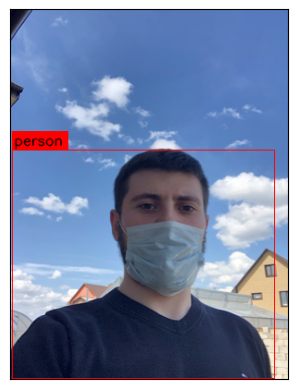

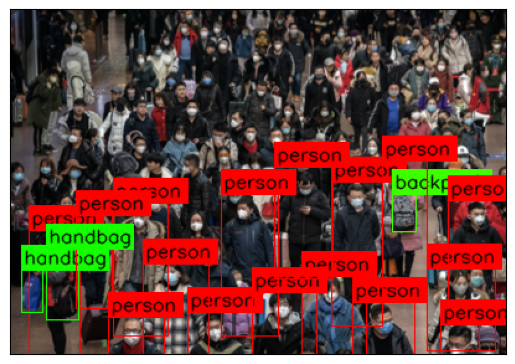

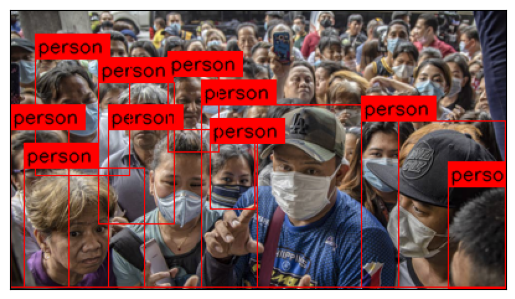

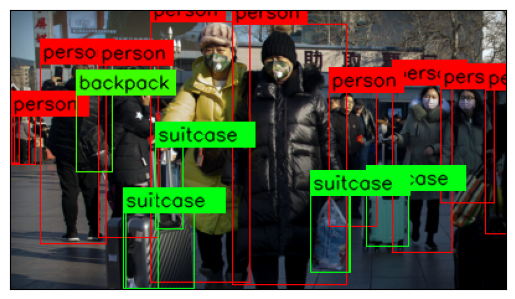

In [4]:
# Run batched inference on a list of images
list_images = [
    r"D:\I4-AMS\AI\Project_final\face-mask-detection\images\maksssksksss107.png",
    r"D:\I4-AMS\AI\Project_final\face-mask-detection\images\maksssksksss603.png",
    r"D:\I4-AMS\AI\Project_final\face-mask-detection\images\maksssksksss52.png",
    r"D:\I4-AMS\AI\Project_final\face-mask-detection\images\maksssksksss108.png"
]

for image in list_images:
    make_predictions_ylov8(image)

As you can see Yolo detect the people in the images (as long as there are not too many) but of course can't differentiate between masked and non masked ones as it has not yet been trained for it (these are not classes of the Yolov8 model).

# XML parser

Our dataset is made of a few hundred images. For each image we have a xml file with one rectangle (xmin, xmax, ymin, ymax) and the class (masked, unmasked, partially masked) per face contained in the image .

First we start by writting a xml parser to retrieve the annotations for each detected objects (faces) in the images.

In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

annotations_dir = r"D:\I4-AMS\AI\Project_final\face-mask-detection\annotations"

df = pd.DataFrame()  # Initialize an empty DataFrame

for dirname, _, filenames in os.walk(annotations_dir):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)

        # Check if the file is empty
        if os.path.getsize(file_path) == 0:
            print(f"Skipping empty XML file: {file_path}")
            continue

        try:
            tree = ET.parse(file_path)
            root = tree.getroot()
        except ET.ParseError as e:
            print(f"Skipping corrupt XML file: {file_path} - Error: {e}")
            continue  # Skip this file if there's an error

        list_tag_shared = []
        list_text_shared = []

        index = 0

        for child in root:
            if len(child) > 0:
                list_tag_not_shared = []
                list_text_not_shared = []

                for i in range(len(child)):
                    if len(child[i]) == 0:
                        list_tag_not_shared.append(child[i].tag)
                        list_text_not_shared.append(child[i].text)

                    for j in range(len(child[i])):
                        list_tag_not_shared.append(child[i][j].tag)
                        list_text_not_shared.append(child[i][j].text)

                if child.tag == "size":
                    index += 1
                    list_tag_shared += list_tag_not_shared
                    list_text_shared += list_text_not_shared
                else:
                    # Create DataFrame for each object
                    new_data = pd.DataFrame(
                        [list_text_shared + list_text_not_shared],
                        columns=list_tag_shared + list_tag_not_shared
                    )
                    df = pd.concat([df, new_data], ignore_index=True)
            else:
                list_tag_shared.append(child.tag)
                list_text_shared.append(child.text)

# Save DataFrame to CSV for debugging
df.to_csv("annotations_processed.csv", index=False)
print("XML processing complete. Data saved to annotations_processed.csv")


In [7]:
df.head()

folder           filename width height depth segmented          name   
0  images  maksssksksss0.png   512    366     3         0  without_mask  \
1  images  maksssksksss0.png   512    366     3         0     with_mask   
2  images  maksssksksss0.png   512    366     3         0  without_mask   
3  images  maksssksksss1.png   400    156     3         0     with_mask   
4  images  maksssksksss1.png   400    156     3         0     with_mask   

          pose truncated occluded difficult xmin ymin xmax ymax  
0  Unspecified         0        0         0   79  105  109  142  
1  Unspecified         0        0         0  185  100  226  144  
2  Unspecified         0        0         0  325   90  360  141  
3  Unspecified         0        0         0  321   34  354   69  
4  Unspecified         0        0         0  224   38  261   73

# Pre-process of the dataset

Now we search columns that have only one value and delete them from the Dataframe.

In [8]:
list_columns_len_1 = []
for column in df.columns:
    print(column, len(df[column].value_counts()))
    if len(df[column].value_counts()) == 1:
        list_columns_len_1.append(column)

folder 1
filename 853
width 39
height 104
depth 1
segmented 1
name 3
pose 1
truncated 1
occluded 1
difficult 1
xmin 406
ymin 270
xmax 411
ymax 356


In [9]:
print(list_columns_len_1)

['folder', 'depth', 'segmented', 'pose', 'truncated', 'occluded', 'difficult']


In [10]:
df = df.loc[:,~df.columns.isin(list_columns_len_1)]
df.head()

filename width height          name xmin ymin xmax ymax
0  maksssksksss0.png   512    366  without_mask   79  105  109  142
1  maksssksksss0.png   512    366     with_mask  185  100  226  144
2  maksssksksss0.png   512    366  without_mask  325   90  360  141
3  maksssksksss1.png   400    156     with_mask  321   34  354   69
4  maksssksksss1.png   400    156     with_mask  224   38  261   73

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   width     4072 non-null   object
 2   height    4072 non-null   object
 3   name      4072 non-null   object
 4   xmin      4072 non-null   object
 5   ymin      4072 non-null   object
 6   xmax      4072 non-null   object
 7   ymax      4072 non-null   object
dtypes: object(8)
memory usage: 254.6+ KB


We transform the relevant columns into float32 dtype.

In [12]:
list_columns_float = ['width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
df[list_columns_float] = df[list_columns_float].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  4072 non-null   object 
 1   width     4072 non-null   float32
 2   height    4072 non-null   float32
 3   name      4072 non-null   object 
 4   xmin      4072 non-null   float32
 5   ymin      4072 non-null   float32
 6   xmax      4072 non-null   float32
 7   ymax      4072 non-null   float32
dtypes: float32(6), object(2)
memory usage: 159.2+ KB


Yolov8 does not use "xmin", "xmax", "ymin", "ymax", but the xy center of the rectangles and their width and heigth.

In [13]:
df['w'] = (df['xmax'] - df['xmin'])/df['width']
df['h'] = (df['ymax'] - df['ymin'])/df['height']
df['x'] = (df['xmin']/df['width']) + df['w']/2
df['y'] = (df['ymin']/df['height']) + df['h']/2

Now we look at the data, and more particularly at the *name* and *filename* columns.

In [144]:
df.name.value_counts()

name
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

<Axes: xlabel='name', ylabel='count'>

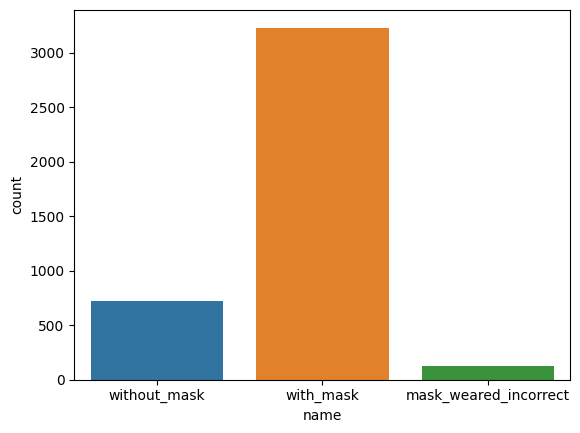

In [14]:
sns.countplot(x=df.name)

There is a disproportionate number of people with mask compared to the two other possibilities (without mask and mask worn incorrectly).

We can now count the number of object found per file and describe the results.

In [15]:
df.filename.value_counts()

filename
maksssksksss603.png    115
maksssksksss518.png     83
maksssksksss240.png     61
maksssksksss260.png     53
maksssksksss52.png      51
                      ... 
maksssksksss601.png      1
maksssksksss600.png      1
maksssksksss60.png       1
maksssksksss6.png        1
maksssksksss482.png      1
Name: count, Length: 853, dtype: int64

In [16]:
df.filename.value_counts().describe()

count    853.000000
mean       4.773740
std        7.394114
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max      115.000000
Name: count, dtype: float64

Some files have a dispropotionate amount of detected objects compared to the majority of the dataset, but the vast majority has less than 6 masks per images.

We map the 3 labels.

In [17]:
name_map = {'without_mask':'0', 'with_mask':'1', 'mask_weared_incorrect':'2'}
df['name'] = df['name'].map(name_map)

In [149]:
df.head()

filename  width  height name   xmin   ymin   xmax   ymax   
0  maksssksksss0.png  512.0   366.0    0   79.0  105.0  109.0  142.0  \
1  maksssksksss0.png  512.0   366.0    1  185.0  100.0  226.0  144.0   
2  maksssksksss0.png  512.0   366.0    0  325.0   90.0  360.0  141.0   
3  maksssksksss1.png  400.0   156.0    1  321.0   34.0  354.0   69.0   
4  maksssksksss1.png  400.0   156.0    1  224.0   38.0  261.0   73.0   

          w         h         x         y  
0  0.058594  0.101093  0.183594  0.337432  
1  0.080078  0.120219  0.401367  0.333333  
2  0.068359  0.139344  0.668945  0.315574  
3  0.082500  0.224359  0.843750  0.330128  
4  0.092500  0.224359  0.606250  0.355769

We can plot some images and the boxes for each object found. 
When we load the images we resize them so we also need to resize the boxes.

<h4>With PIL and Matplotlib</h4>

In [18]:

def plot_images(fig_shape, size=(200,200)):
    
    list_images = df.filename.unique()[fig_shape.flatten()]  # Flattens fig_shape to obtain a list of image ids
    
    color_map = {'0': 'r', '1': 'g', '2': 'b'}  # Dictionary indicating the color coding depending on the category
    
    image_folder = r"D:\I4-AMS\AI\Project_final\face-mask-detection\images"  # Updated path

    fig, ax = plt.subplots(fig_shape.shape[0], fig_shape.shape[1], figsize=(10, 10)) 
    
    image_id = 0  # Starts by the first id
    
    for row in ax:
        for col in row:
            name_image = list_images[image_id]  # Selects the image_id in the list
            image = os.path.join(image_folder, name_image)  # Image path
            
            image = Image.open(image)  # Opens the image with PIL
            image = image.convert("RGB")  # Converts it to RGB
            image = image.resize(size)  # Resizes the image to size
            
            image_array = np.asarray(image)  # Converts the image to a numpy array
            
            col.imshow(image_array)  # Plots the image array
            
            col.set_xticks([])  # Deletes x ticks 
            col.set_yticks([])  # Deletes y ticks
            
            boxes_df = df[df.filename == name_image][['name', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']]  # Selects all the boxes of the image
            
            for box_id in boxes_df.index:  # Iterates over the indexes
                box = boxes_df.loc[box_id]  # Selects the box
                color = color_map[box['name']]  # Selects the color from the category

                ratio_x = size[0] / box['width']  # Computes the ratio in the x direction to resize the box
                ratio_y = size[1] / box['height']  # Computes the ratio in the y direction to resize the box
                
                # Resizes each x and y value
                x_min = box['xmin'] * ratio_x
                y_min = box['ymin'] * ratio_y
                x_max = box['xmax'] * ratio_x
                y_max = box['ymax'] * ratio_y
                
                width  = x_max - x_min  # Computes the width of the box
                height = y_max - y_min  # Computes the height of the box
                
                col.add_patch(Rectangle((x_min, y_min), width, height, fc='none', color=color))  # Adds the box to the image
            
            image_id += 1  # Increments the image_id


In [19]:
figure_shape = np.random.randint(len(df.filename.unique()), size=(3, 3)) #selct random images from df and put their id in a (size) matrix

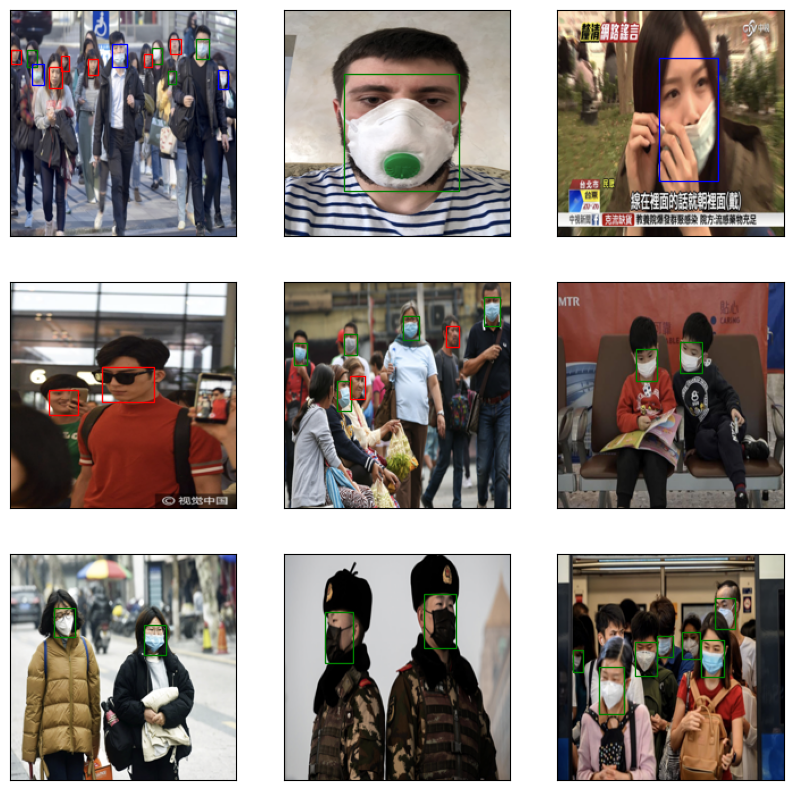

In [20]:
plot_images(figure_shape)

<h4>With OpenCV</h4>

In [21]:
def plot_images_OpenCV(fig_shape, size=(200,200)):
    
    list_images = df.filename.unique()[fig_shape.flatten()] #flattens fig_shpae to obtain a list of image ids
    
    color_map = {'0':(255,0,0), '1':(0,255,0), '2':(0,0,255)} #dictionary indicating the color coding depending on the category (rgb values as we use OpenCV)
    
    class_names = {'0': 'No mask', '1':'Mask', '2':'Incorrect'}
    
    text_padding = {'0': 45, '1': 26, '2': 44}
    
    image_folder =  r"D:\I4-AMS\AI\Project_final\face-mask-detection\images" 
    fig, ax = plt.subplots(fig_shape.shape[0],fig_shape.shape[1], figsize=(10, 10))
    
    image_id = 0 #starts by the first id
    
    for row in ax:
        for col in row:
            name_image = list_images[image_id] #selects the image_id in the list
            
            image = os.path.join(image_folder, name_image) #image path
            image = cv2.imread(image) #opens the image with OpenCV
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converts it to RGB
            image =  cv2.resize(image, size) #resizes the image to size

            col.set_xticks([]) #deletes x ticks 
            col.set_yticks([]) #deletes y ticks 
            
            boxes_df = df[df.filename == name_image][['name','width','height', 'xmin', 'ymin', 'xmax', 'ymax']] #selects all the boxes of the image
            
            for box_id in boxes_df.index: #iterates other the indexes
                
                box = boxes_df.loc[box_id] #select the box
                color  = color_map[box['name']] #selects the color from the category

                ratio_x = size[0]/box['width'] #computes the ratio in the x direction to resize the box
                ratio_y = size[1]/box['height'] #computes the ratio in the y direction to resize the box
                
                #resizes each x and y value
                #we use round because cv2.rectangle needs int values
                x_min = round(box['xmin']*ratio_x)
                y_min = round(box['ymin']*ratio_y)
                x_max = round(box['xmax']*ratio_x)
                y_max = round(box['ymax']*ratio_y)
                
                #cv2.rectangle needs the top left point and the bottom right point to draw the box
                start_point = (x_min, y_min) 
                end_point = (x_max, y_max)
                
                cv2.rectangle(image, start_point, end_point, color, 1) #draws the box to the image
                
                #this part adds the rectangle + class on top of the box
                class_name = class_names[box['name']]
                padding = text_padding[box['name']]
                
                start_rect_text = (x_min, round(y_min - 10))
                end_rect_text = (round(x_min + padding), y_min)

                start_text = (round(x_min + 2), round(y_min - 2))
        
                cv2.rectangle(image, start_rect_text, end_rect_text, color, -1)
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(image,class_name,start_text, font, 0.3,(0,0,0),1,cv2.LINE_AA)
                
            col.imshow(image) #shows the image
            image_id += 1 #increments the image_id

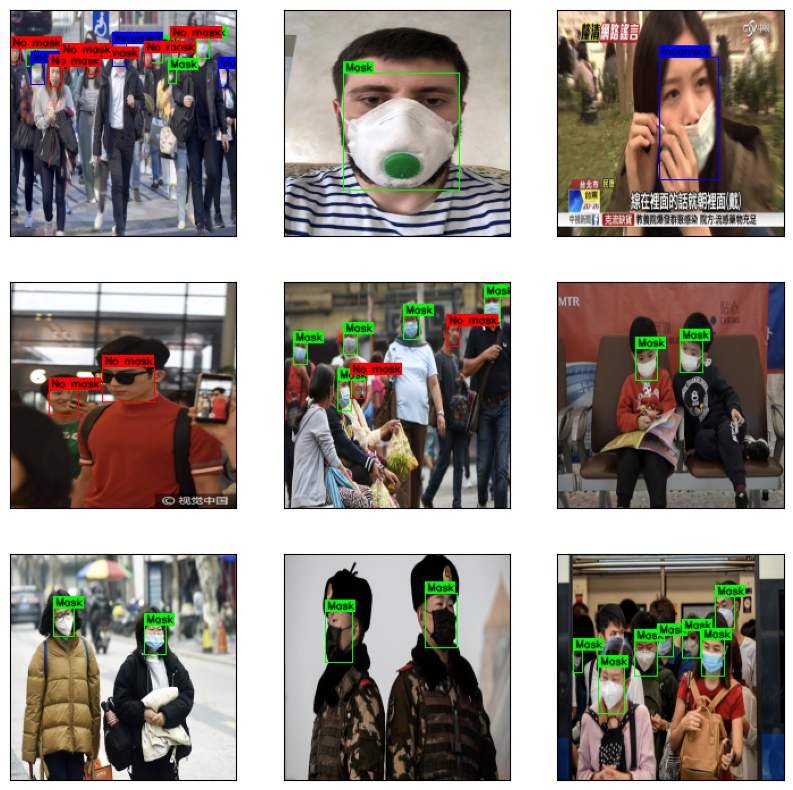

In [22]:
plot_images_OpenCV(figure_shape)

# Yolov8 custom dataset

Yolov8 expect a certain folder and file arrangement.
First the folders should be divided into "images" and "annotation". Inside each of these folders should be present a "train", "valid", and "test" folder containing the images and corresponding annotations. <br>
The annotations should be present as text files containing the classes and x, y, w, h values of each detected object (one text file per images).

We are now going to build this dataset.

In [23]:
output_folder = r"D:\I4-AMS\AI\Project_final\face-mask-detection\annotations"

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each unique filename
for filename in df.filename.unique():
    # Fix the file path construction
    file_path = os.path.join(output_folder, filename.replace('.png', '.txt'))

    # Ensure dataframe has required columns
    if {'name', 'x', 'y', 'w', 'h'}.issubset(df.columns):
        dfstr = df[df.filename == filename].to_string(header=False, index=False, columns=['name', 'x', 'y', 'w', 'h'])

        # Write data to file
        with open(file_path, 'w') as f:  # Use 'w' to overwrite instead of 'a' (append)
            f.write(dfstr)
    else:
        print(f"Missing required columns in df for {filename}")


We split the images and annotations into train, val, split sets.

In [24]:
images = df.filename.unique()
annotations = [filename.replace('.png', '.txt') for filename in images]

train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

Copies the images and annotations for the selected set.

In [116]:
def make_folder_mv_file(folder, images, annotations, type_set):
    
    if not os.path.exists(folder + 'images'):
        os.makedirs(folder + 'images')
        
    if not os.path.exists(folder + 'images/' + type_set):
        os.makedirs(folder + 'images/' + type_set)
    
    if not os.path.exists(folder + 'labels'):
        os.makedirs(folder + 'labels')
        
    if not os.path.exists(folder + 'labels/' + type_set):
        os.makedirs(folder + 'labels/' + type_set)

    for file, annotation in zip(images, annotations):
        shutil.copyfile('D:/I4-AMS/AI/Project final/face-mask-detection/images/' + file, folder + 'images/' + type_set + '/' + file)
        shutil.move('D:/I4-AMS/AI/Project final/face-mask-detection/annotations/' + annotation, folder + 'labels/' + type_set + '/' + annotation)

In [25]:
def make_folder_mv_file(folder, images, annotations, type_set):
    # Construct paths dynamically using os.path.join()
    images_folder = os.path.join(folder, 'images', type_set)
    labels_folder = os.path.join(folder, 'labels', type_set)
    
    # Check and create required directories if they don't exist
    os.makedirs(images_folder, exist_ok=True)
    os.makedirs(labels_folder, exist_ok=True)

    # Loop through the images and annotations, and move/copy the files
    for file, annotation in zip(images, annotations):
        # Construct full source and destination paths using os.path.join()
        src_image_path = os.path.join(r"D:\I4-AMS\AI\Project_final\face-mask-detection\images", file)
        dst_image_path = os.path.join(images_folder, file)
        
        src_annotation_path = os.path.join(r"D:\I4-AMS\AI\Project_final\face-mask-detection\annotations", annotation)
        dst_annotation_path = os.path.join(labels_folder, annotation)

        # Copy image file
        shutil.copyfile(src_image_path, dst_image_path)

        # Move annotation file
        shutil.move(src_annotation_path, dst_annotation_path)


In [26]:
# path folder store data files
folder = r"D:\I4-AMS\AI\Project_final\face-mask-detection\working"
train_folder = r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\images\train"
val_folder = r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\images\val"
test_folder = r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\images\test"


In [27]:
make_folder_mv_file(folder, train_images, train_annotations, 'train')
make_folder_mv_file(folder, val_images, val_annotations, 'val')
make_folder_mv_file(folder, test_images, test_annotations, 'test')

Yolov8 asks for a yaml file containing the folders for each set, the number of class, and the names of the classes.


train: r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\images\train <br>
val: r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\images\val <br>
test: r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\images\test <br> <br> # number of classes <br>
nc: 3 <br> <br> # class names <br>
names: ['without_mask', 'with_mask', 'mask_weared_incorrect']

In [30]:
yaml_dataset_file = open(r"D:\I4-AMS\AI\Project_final\face-mask-detection\mask_data.yaml", 'w')
file_lines = ['train: '+ train_folder, '\nval: '+ val_folder,'\ntest: '+ test_folder, '\n', '\n# number of classes', '\nnc: ' + str(len(name_map)), '\n', '\n# class names', '\nnames: ' + str(list(name_map.keys()))]
yaml_dataset_file.writelines(file_lines)
yaml_dataset_file.close()

# Yolov8 trained on custom dataset

Now we train the Yolov8 model on our costum dataset.

In [31]:
import os
from ultralytics import YOLO

os.environ["WANDB_MODE"] = "offline"  # Disable Weights & Biases logging

#  dataset exists
dataset_path = r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\images\val"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path '{dataset_path}' not found. Please check mask_data.yaml.")

# Load the model
model_path = r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\runs\detect\yolov8n_custom\weights\best.pt"
if os.path.isfile(model_path):
    model = YOLO(model_path)
else:
    model = YOLO(r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\yolov8n.pt")

# Training
history = model.train(
    data= r"D:\I4-AMS\AI\Project_final\face-mask-detection\mask_data.yaml",
    imgsz=640,
    epochs=50,
    batch=8,
    name='yolov8n_custom'
)



New https://pypi.org/project/ultralytics/8.3.63 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.59  Python-3.12.0 torch-2.3.0+cpu CPU (11th Gen Intel Core(TM) i5-11300H 3.10GHz)
engine\trainer: task=detect, mode=train, model=D:\I4-AMS\AI\Project_final\face-mask-detection\working\yolov8n.pt, data=D:\I4-AMS\AI\Project_final\face-mask-detection\mask_data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualiz

train: Scanning D:\I4-AMS\AI\Project_final\face-mask-detection\working\labels\train... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:04<00:00, 150.10it/s]

train: New cache created: D:\I4-AMS\AI\Project_final\face-mask-detection\working\labels\train.cache



val: Scanning D:\I4-AMS\AI\Project_final\face-mask-detection\working\labels\val... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 157.39it/s]

val: New cache created: D:\I4-AMS\AI\Project_final\face-mask-detection\working\labels\val.cache


Plotting labels to runs\detect\yolov8n_custom7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\yolov8n_custom7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.629      2.498      1.304         37        640: 100%|██████████| 86/86 [08:00<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]

                   all         85        320       0.97       0.28      0.372      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.317      1.453      1.097          4        640: 100%|██████████| 86/86 [07:21<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.74s/it]

                   all         85        320      0.853      0.419       0.46      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.331      1.303      1.101          5        640: 100%|██████████| 86/86 [07:10<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]

                   all         85        320      0.804      0.419      0.473      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.268      1.186      1.077         33        640: 100%|██████████| 86/86 [07:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]

                   all         85        320      0.856      0.438      0.515       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.229      1.066      1.068         12        640: 100%|██████████| 86/86 [07:02<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]

                   all         85        320      0.674      0.588      0.603      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.224      1.007       1.05         18        640: 100%|██████████| 86/86 [06:55<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.71s/it]

                   all         85        320      0.906      0.502       0.58      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.168     0.9349      1.039          6        640: 100%|██████████| 86/86 [07:03<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]

                   all         85        320      0.772      0.608       0.64      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.189     0.8969      1.049          9        640: 100%|██████████| 86/86 [07:05<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]

                   all         85        320      0.812      0.577      0.632      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.163     0.8716      1.039          5        640: 100%|██████████| 86/86 [07:01<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]

                   all         85        320      0.762      0.573      0.633      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.169     0.8505      1.042         26        640: 100%|██████████| 86/86 [07:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]

                   all         85        320      0.689      0.713       0.72      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.164     0.8429      1.044         23        640: 100%|██████████| 86/86 [07:06<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

                   all         85        320      0.817      0.607      0.731      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.158     0.8026      1.026         29        640: 100%|██████████| 86/86 [07:03<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]

                   all         85        320      0.861      0.685      0.719      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.139     0.7777      1.014          9        640: 100%|██████████| 86/86 [06:59<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]

                   all         85        320      0.747      0.658      0.694      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.125     0.7542      1.014         12        640: 100%|██████████| 86/86 [07:07<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.54s/it]

                   all         85        320      0.877       0.68      0.732      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.118     0.7428      1.007         19        640: 100%|██████████| 86/86 [07:14<00:00,  5.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.59s/it]

                   all         85        320      0.928      0.587      0.702      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.097     0.6986     0.9883         20        640: 100%|██████████| 86/86 [07:13<00:00,  5.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

                   all         85        320      0.784      0.711      0.743      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.081     0.6932     0.9975         21        640: 100%|██████████| 86/86 [07:04<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]

                   all         85        320      0.608      0.762      0.729      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.095     0.6774     0.9895         15        640: 100%|██████████| 86/86 [07:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]

                   all         85        320       0.87      0.714      0.755      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.097     0.6856     0.9921         16        640: 100%|██████████| 86/86 [07:05<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.52s/it]

                   all         85        320      0.921      0.684      0.773      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.096     0.6783     0.9947         12        640: 100%|██████████| 86/86 [07:05<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]

                   all         85        320      0.859      0.617      0.723      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.075     0.6763     0.9982          9        640: 100%|██████████| 86/86 [06:44<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]

                   all         85        320      0.846      0.735      0.769      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.065     0.6525     0.9873          4        640: 100%|██████████| 86/86 [07:05<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

                   all         85        320      0.865      0.681      0.774      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.026      0.631     0.9802         15        640: 100%|██████████| 86/86 [06:46<00:00,  4.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

                   all         85        320      0.912      0.673       0.73      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.046     0.6254      0.975         14        640: 100%|██████████| 86/86 [06:48<00:00,  4.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.51s/it]

                   all         85        320      0.808      0.727      0.756      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.043     0.6283     0.9724         30        640: 100%|██████████| 86/86 [07:04<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.58s/it]

                   all         85        320      0.895      0.648      0.766      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.051     0.6251     0.9788         15        640: 100%|██████████| 86/86 [07:08<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

                   all         85        320      0.838      0.704      0.771      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.024     0.6218     0.9726         23        640: 100%|██████████| 86/86 [07:09<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.52s/it]

                   all         85        320      0.922       0.72      0.789      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.022      0.598     0.9708         21        640: 100%|██████████| 86/86 [07:05<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]

                   all         85        320      0.896      0.709      0.776      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G       1.04     0.6095     0.9743         17        640: 100%|██████████| 86/86 [07:09<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

                   all         85        320      0.907      0.717      0.768      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.9971     0.5829     0.9706          6        640: 100%|██████████| 86/86 [06:45<00:00,  4.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.52s/it]

                   all         85        320      0.853      0.713      0.757      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.012     0.5806     0.9632         29        640: 100%|██████████| 86/86 [07:05<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]

                   all         85        320      0.863      0.736      0.782      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.9983     0.5711     0.9643         18        640: 100%|██████████| 86/86 [07:10<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.69s/it]

                   all         85        320      0.829      0.716      0.766      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.005     0.5705      0.966         23        640: 100%|██████████| 86/86 [07:05<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]

                   all         85        320      0.844      0.688      0.778      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.9809     0.5508     0.9482         14        640: 100%|██████████| 86/86 [07:07<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]

                   all         85        320      0.818      0.694      0.784      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.9897     0.5496     0.9607         29        640: 100%|██████████| 86/86 [07:06<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]

                   all         85        320      0.805      0.702      0.774      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.9717     0.5482     0.9477          6        640: 100%|██████████| 86/86 [07:08<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.51s/it]

                   all         85        320      0.819      0.711      0.777      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.9665     0.5399      0.949         15        640: 100%|██████████| 86/86 [07:00<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]

                   all         85        320      0.808       0.72      0.773      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.9568     0.5231     0.9499         38        640: 100%|██████████| 86/86 [07:06<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.54s/it]

                   all         85        320      0.887      0.678      0.785      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.9463     0.5223     0.9499         14        640: 100%|██████████| 86/86 [07:06<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.54s/it]

                   all         85        320      0.867      0.725      0.811      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.9782     0.5389     0.9438         27        640: 100%|██████████| 86/86 [07:06<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.63s/it]

                   all         85        320      0.892       0.66      0.785      0.561


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      0.931     0.5071     0.9364          5        640: 100%|██████████| 86/86 [06:40<00:00,  4.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.51s/it]

                   all         85        320      0.885      0.708      0.779      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.9116     0.4792     0.9281          5        640: 100%|██████████| 86/86 [06:58<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]

                   all         85        320      0.908      0.663      0.754      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9326     0.4856     0.9321          8        640: 100%|██████████| 86/86 [06:56<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]

                   all         85        320      0.848      0.636       0.72      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.9094     0.4672      0.936          7        640: 100%|██████████| 86/86 [06:59<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]

                   all         85        320      0.718      0.743      0.744      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.8968     0.4649     0.9249         24        640: 100%|██████████| 86/86 [06:37<00:00,  4.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]

                   all         85        320      0.843      0.701      0.769      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8973     0.4539     0.9206         12        640: 100%|██████████| 86/86 [07:20<00:00,  5.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.59s/it]

                   all         85        320      0.867      0.678      0.789      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.8759      0.451     0.9224          2        640: 100%|██████████| 86/86 [07:00<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.67s/it]

                   all         85        320      0.874      0.686      0.789      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.8766     0.4468     0.9164         11        640: 100%|██████████| 86/86 [07:18<00:00,  5.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]

                   all         85        320      0.797      0.724      0.782      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.8772     0.4512     0.9165         10        640: 100%|██████████| 86/86 [07:03<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.58s/it]

                   all         85        320      0.784      0.728      0.791      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8709      0.435     0.9211          5        640: 100%|██████████| 86/86 [07:02<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.69s/it]

                   all         85        320      0.773      0.728      0.783       0.55



50 epochs completed in 6.124 hours.
Optimizer stripped from runs\detect\yolov8n_custom7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolov8n_custom7\weights\best.pt, 6.2MB

Validating runs\detect\yolov8n_custom7\weights\best.pt...
Ultralytics 8.3.59  Python-3.12.0 torch-2.3.0+cpu CPU (11th Gen Intel Core(TM) i5-11300H 3.10GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


                   all         85        320      0.887      0.678      0.785      0.572
          without_mask         18         31      0.869      0.641      0.776      0.544
             with_mask         79        283      0.983      0.894      0.978      0.693
 mask_weared_incorrect          6          6      0.811        0.5        0.6      0.481
Speed: 2.8ms preprocess, 129.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\yolov8n_custom7


We look at the results using the test folder and a selection of random images.

In [32]:
def make_predictions(image, model=model):
    result = model(image, conf=0.5, verbose=False)[0]

    color_map = {0:(255,0,0), 1:(0,255,0), 2:(0,0,255)} #dictionary indicating the color coding depending on the category (rgb values as we use OpenCV)
    
    class_names = {0: 'No mask', 1:'Mask', 2:'Incorrect'}
    
    text_padding = {0: 58, 1: 34, 2: 57}
    
    boxes = result.boxes  # Boxes object for bbox outputs
    probs = result.probs  # Probs object for classification outputs
    
    image = cv2.imread(image) #opens the image with OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converts it to RGB

    fig, ax = plt.subplots()
    ax.set_xticks([]) #deletes x ticks 
    ax.set_yticks([]) #deletes y ticks 
    
    if len(boxes.xywh) > 5:
        annotation = False
    else:
        annotation = True
    
    for xywh, classes in zip(boxes.xywh, boxes.cls):
        xmin = round(xywh[0].item() - xywh[2].item()/2)
        ymin = round(xywh[1].item() - xywh[3].item()/2)
        xmax = round(xywh[0].item() + xywh[2].item()/2)
        ymax = round(xywh[1].item() + xywh[3].item()/2)
        
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        
        class_object = classes.item()
        
        color = color_map[class_object]
        
        cv2.rectangle(image, start_point, end_point, color, 1) #draws the box to the image
        if annotation:
            
            class_name = class_names[class_object]
            padding = text_padding[class_object]
            
            start_rect_text = (xmin, round(ymin - 10))
            end_rect_text = (round(xmin + padding), ymin)

            start_text = (round(xmin + 2), round(ymin - 2))
        
            cv2.rectangle(image, start_rect_text, end_rect_text, color, -1)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image,class_name,start_text, font, 0.4,(0,0,0),1,cv2.LINE_AA)

    ax.imshow(image) #shows the image

In [35]:
# Define the test image folder
test_folder = r"D:\I4-AMS\AI\Project_final\face-mask-detection\working\images\test\\"

# Get the list of images in the test folder
test_images = [f for f in os.listdir(test_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Shuffle and select 10 random test images
if len(test_images) < 10:
    print("Warning: Less than 10 test images found, using all available images.")
    random_ids = np.arange(len(test_images))  # Use all images if fewer than 10
else:
    random_ids = np.random.choice(len(test_images), size=10, replace=False)  # Select 10 unique random indices

test_images_shuffled = np.array([os.path.join(test_folder, test_images[i]) for i in random_ids])

# Verify selected images
print("Selected test images:", test_images_shuffled)


Selected test images: ['D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssksksss786.png' 'D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssksksss83.png' 'D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssksksss151.png'
 'D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssksksss696.png' 'D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssksksss500.png' 'D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssksksss668.png'
 'D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssksksss540.png' 'D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssksksss67.png' 'D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssksksss638.png'
 'D:\\I4-AMS\\AI\\Project_final\\face-mask-detection\\working\\images\\test\\\\maksssk

In [33]:
test_images_shuffled = np.array([test_folder + image for image in test_images])
random_ids = np.random.randint(len(test_images_shuffled), size=10)

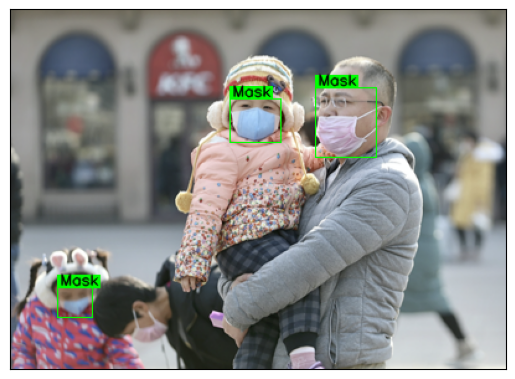

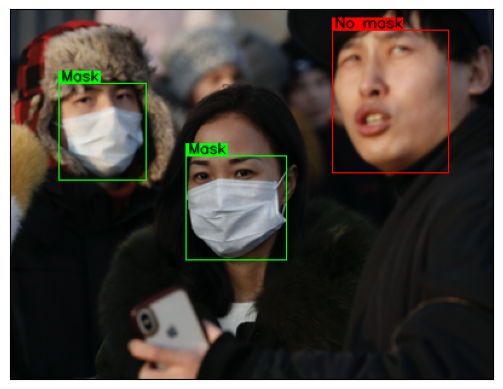

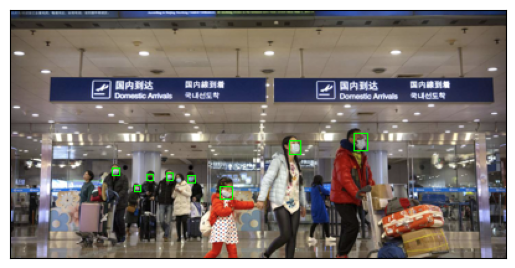

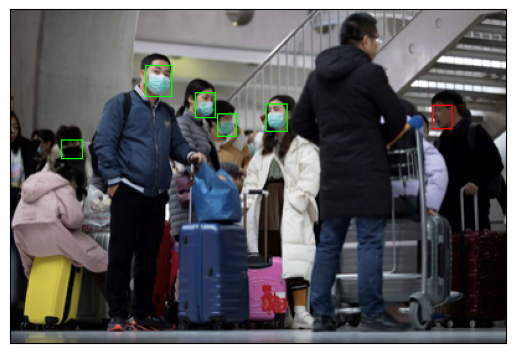

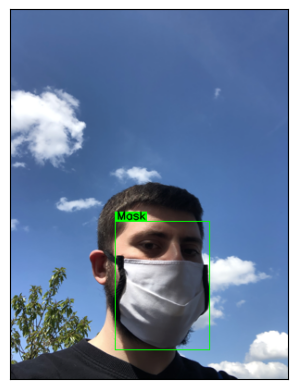

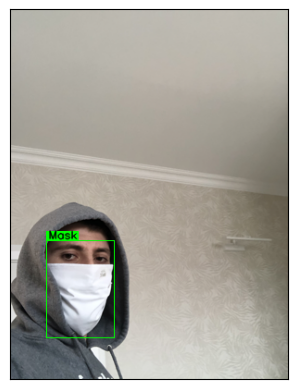

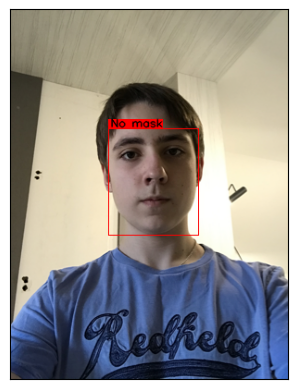

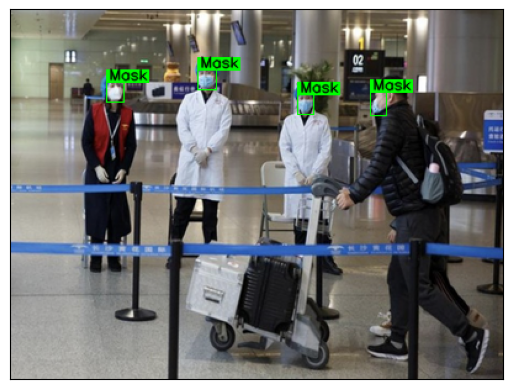

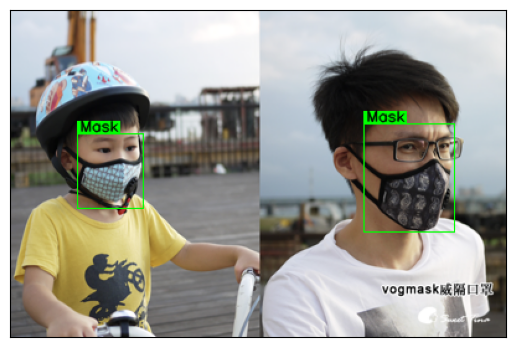

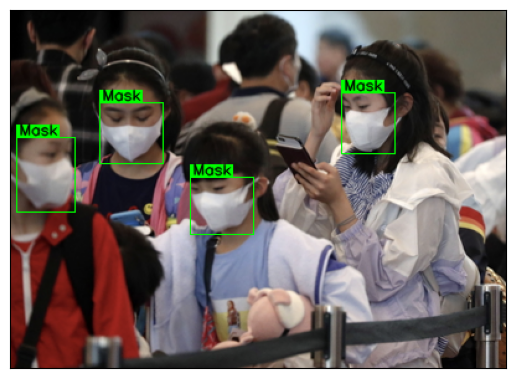

In [36]:
for image in test_images_shuffled:
    make_predictions(image)


So this is a quick rundown on how to use Yolo and create a custom dataset. I'm pretty pleased with the results and will of course try to learn more about Yolo and how to use it for object detection.

# Saving and loading

Yolo automaticaly save the best and last weights in the folder "/runs/detect/yolov8n_custom7/weights/".

In [42]:
new_model = YOLO(r"D:\I4-AMS\AI\Project_final\face-mask-detection\runs\detect\yolov8n_custom7\weights\best.pt")


Now we use the model has been loaded saved for prediction

below code use for testing image, we can use anywhere of the image just load path to code it will predict to use The code below is used for testing images. We can use it anywhere by loading the image path into the code, and it will make predictions.


0: 320x640 1 with_mask, 181.9ms
Speed: 13.3ms preprocess, 181.9ms inference, 13.9ms postprocess per image at shape (1, 3, 320, 640)


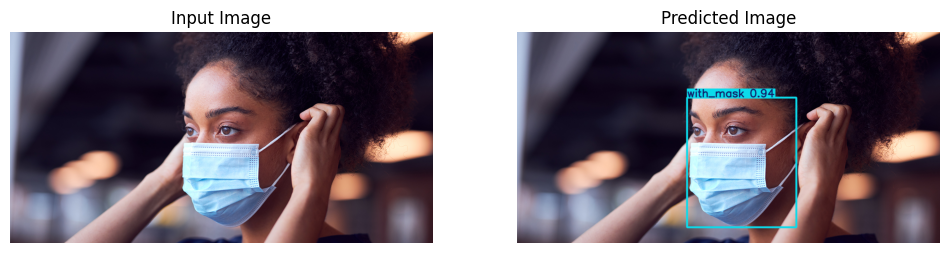

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLO model
model = YOLO(r"D:\I4-AMS\AI\Project_final\face-mask-detection\runs\detect\yolov8n_custom7\weights\best.pt")

# Load input image (template)
input_image_path = r"D:\I4-AMS\AI\Project_final\face-mask-detection\maksssksksss62.png"

input_image = cv2.imread(input_image_path)
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

# Run YOLO prediction
results = model(input_image)

# Process results
for result in results:
    predicted_image = result.plot()

predicted_image_rgb = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

# Display input and predicted images side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(input_image_rgb)
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(predicted_image_rgb)
ax[1].set_title("Predicted Image")
ax[1].axis("off")

plt.show()


The code below is used for testing videos. We can use it anywhere by loading the video path into the code, and it will make predictions.

In [2]:
import cv2
from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO(r"D:\I4-AMS\AI\Project_final\face-mask-detection\runs\detect\yolov8n_custom7\weights\best.pt")

# Load video
cap = cv2.VideoCapture(r"D:\I4-AMS\AI\Project_final\face-mask-detection\Wear_Mask.mp4")

# Check if video file opened correctly
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Define the desired output size
desired_width = 900
desired_height = 700

# Class names and colors for detection using dictionary
class_names = {0: 'No mask', 1: 'Mask', 2: 'Incorrect'}
colors = [(0, 0, 255), (0, 255, 0), (0, 255, 255)]  # Red for No mask, Green for Mask, Yellow for Incorrect

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame
    frame = cv2.resize(frame, (desired_width, desired_height))

    # Run inference
    results = model(frame)[0]  # Access first element from YOLO results

    # Draw detections on frame
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # Convert tensor to list
        conf = float(box.conf[0])
        cls = int(box.cls[0])

        label = f"{class_names[cls]} {conf:.2f}"
        color = colors[cls]

        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Show output in a larger window
    cv2.imshow("Face Mask Detection", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()



0: 512x640 1 with_mask, 270.6ms
Speed: 6.1ms preprocess, 270.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 258.2ms
Speed: 23.3ms preprocess, 258.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 264.6ms
Speed: 8.3ms preprocess, 264.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 275.0ms
Speed: 12.4ms preprocess, 275.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 482.2ms
Speed: 19.7ms preprocess, 482.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 299.4ms
Speed: 8.3ms preprocess, 299.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 254.6ms
Speed: 4.1ms preprocess, 254.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 298.6ms
Speed: 2.0ms preprocess, 298.6ms inference, 2.0

The code below is used for real-time testing with a webcam. It can be used anywhere, and it will make predictions in real time.

In [5]:
import cv2
from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO(r"D:\I4-AMS\AI\Project_final\face-mask-detection\runs\detect\yolov8n_custom7\weights\best.pt")

# Access the webcam (0 for default camera)
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not access the webcam.")
    exit()

# Define the desired output size
desired_width = 900
desired_height = 700

# Class names and colors for detection using dictionary
class_names = {0: 'No mask', 1: 'Mask', 2: 'Incorrect'}
colors = [(0, 0, 255), (0, 255, 0), (0, 255, 255)]  # Red for No mask, Green for Mask, Yellow for Incorrect

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame
    frame = cv2.resize(frame, (desired_width, desired_height))

    # Run inference
    results = model(frame)[0]  # Access first element from YOLO results

    # Draw detections on frame
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # Convert tensor to list
        conf = float(box.conf[0])
        cls = int(box.cls[0])

        label = f"{class_names[cls]} {conf:.2f}"
        color = colors[cls]

        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Show output in a larger window
    cv2.imshow("Face Mask Detection", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()



0: 512x640 (no detections), 207.6ms
Speed: 7.8ms preprocess, 207.6ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 143.9ms
Speed: 4.0ms preprocess, 143.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 138.4ms
Speed: 4.0ms preprocess, 138.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 96.7ms
Speed: 4.0ms preprocess, 96.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 160.5ms
Speed: 6.1ms preprocess, 160.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 102.0ms
Speed: 4.0ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 218.4ms
Speed: 4.0ms preprocess, 218.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 with_mask, 133.6ms
Speed: 8.1ms preprocess, 133.6ms